# Refactoring discriminator classes in Ignis

In [1]:
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt 
import numpy as np
from copy import deepcopy

%matplotlib inline
plt.rcParams['font.size'] = 16

import qiskit
# from qiskit.ignis.measurement.discriminator.iq_discriminators import \
#     LinearIQDiscriminator, QuadraticIQDiscriminator
from qiskit.result.models import ExperimentResultData
from qiskit import IBMQ

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble

In [2]:
from qiskit import IBMQ
account_provider = IBMQ.load_account()
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project
# provider = IBMQ.get_provider(hub=hub, group=group, project=project)
# #provider = qiskit.IBMQ.get_provider(hub='ibm-q-internal', group='dev-qiskit', project='pulse-testing')
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# backend = provider.get_backend('ibmq-armonk')


provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

/Users/Helena.Zhang@ibm.com/Documents/GitHub/frontend/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


We verify that the backend supports Pulse features by checking the backend configuration. The config provides us with general information about the structure of the backend setup.

In [113]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

For instance, we can find the sampling time for the backend pulses within the backend configuration. This will be a very useful value to us as we build and execute our calibration routines.

In [114]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


The backend defaults provide a starting point for how to use the backend. It contains estimates for qubit frequencies and default programs to enact basic quantum operators. We can access them with the following:

In [115]:
backend_defaults = backend.defaults()

In [119]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974454252026797 GHz.
The sweep will go from 4.954454252026797 GHz to 4.994454252026797 GHz in steps of 1.0 MHz.


Next, we define the pulses we will use for our experiment. We will start with the drive pulse, which is a Gaussian pulse.

Remember the value `dt` from earlier? All durations in pulse are given in terms of `dt`. In the next cell, we define the length of the drive pulse in terms of `dt`.

In [120]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [121]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In order to properly measure our qubits, we need to check the measurement map. This is a hardware constraint. When acquisition is done for one qubit, it is also done on other qubits. We have to respect this constraint when building our program in Pulse. Let's check which group of qubits our qubit is in:

In [122]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

Now we can define our measurement pulse. Rather than hard coding the pulse, we can obtain a calibrated measurement pulse from the backend default instruction schedule map. Because it is frequently calibrated, it is more accurate than defining a measurement pulse ourselves. This measurement pulse also includes acquisition so we do not need to add that in manually.

In [123]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

Lastly, we specify the channels on which we will apply our pulses. Drive, measure, and acquire channels are indexed by qubit index.

In [124]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Now that the pulse parameters have been defined, and we have created the pulse shapes for our experiments, we can proceed to create the pulse schedules.



At each frequency, we will send a drive pulse of that frequency to the qubit and measure immediately after the pulse. The pulse envelopes are independent of frequency, so we will build a reusable `schedule`, and we will specify the drive pulse frequency with a frequency configuration array.

In [125]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

As a sanity check, it's always a good idea to look at the pulse schedule. This is done using `schedule.draw()` as shown below. 

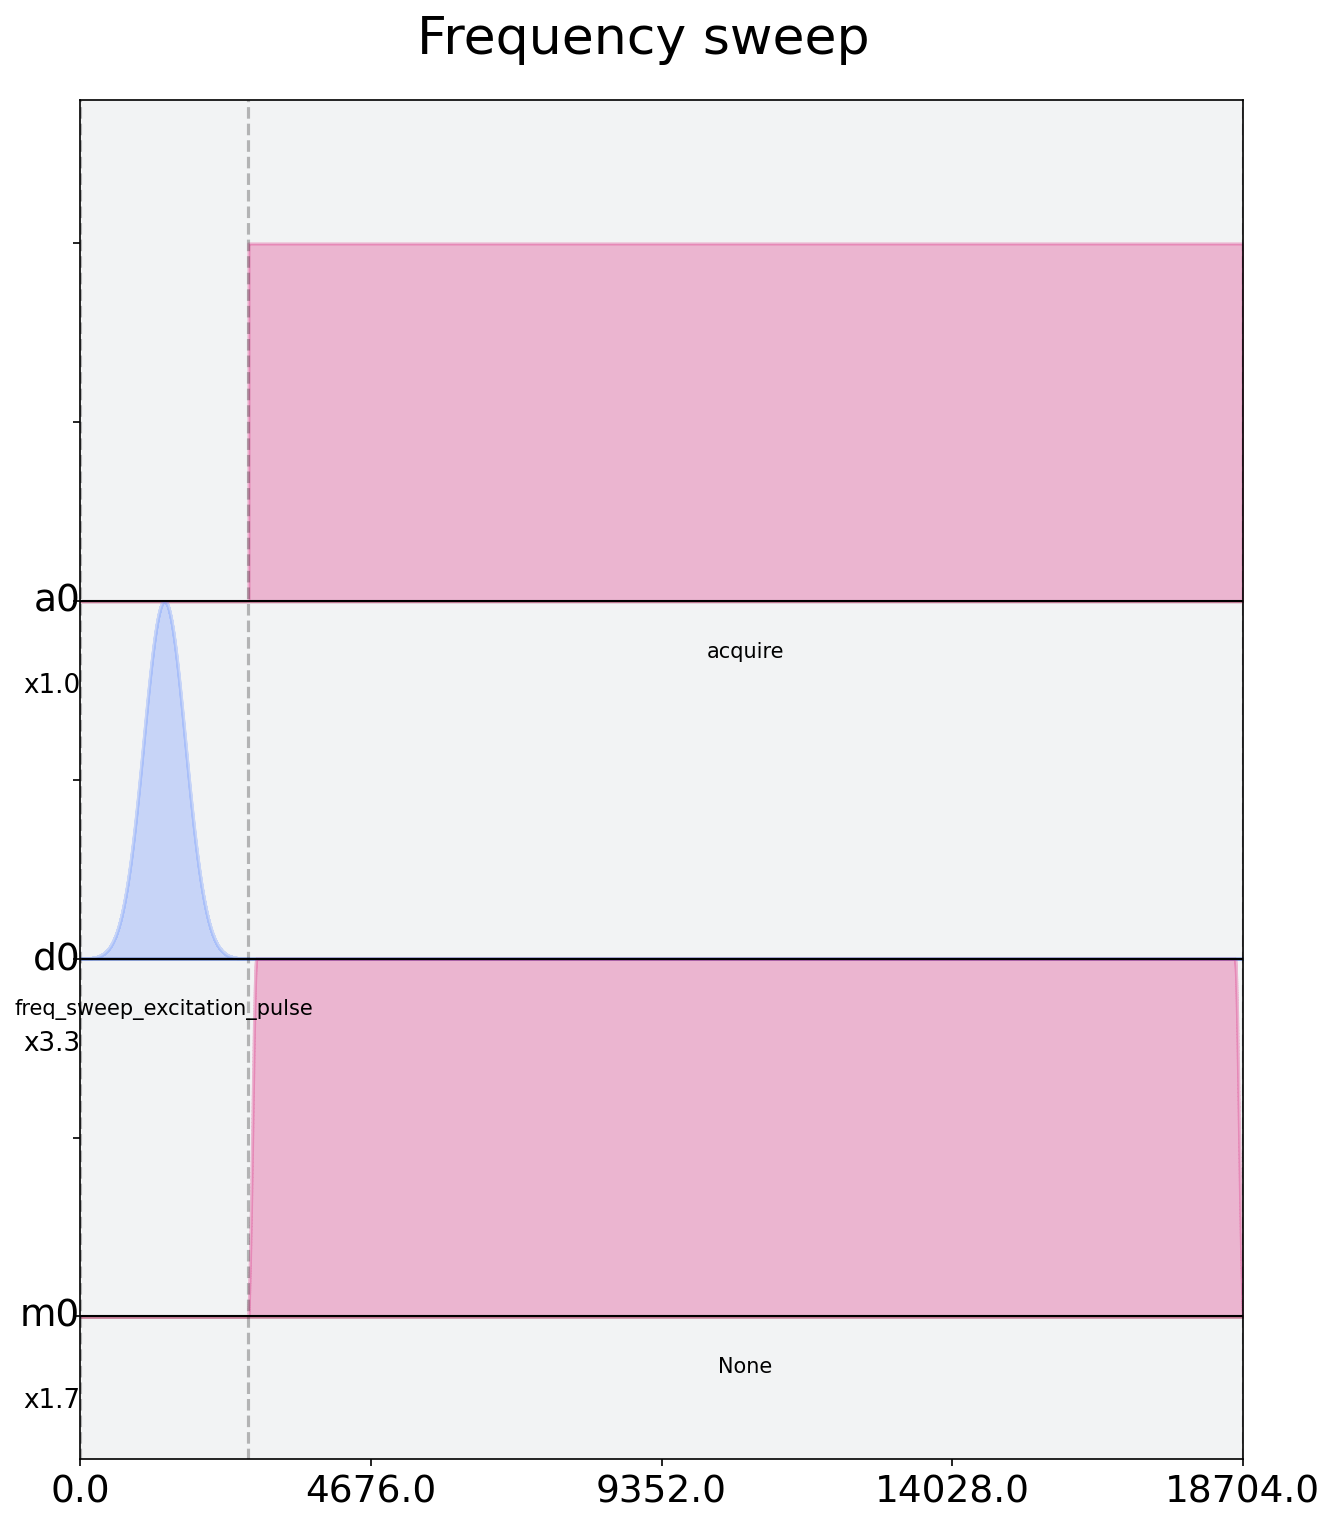

In [126]:
schedule.draw(label=True,plot_all=False)

We assemble the `schedules` and `schedule_frequencies` above into a program object, called a Qobj, that can be sent to the quantum device. We request that each schedule (each point in our frequency sweep) is repeated `num_shots_per_frequency` times in order to get a good estimate of the qubit response.

We also specify measurement settings. `meas_level=0` returns raw data (an array of complex values per shot), `meas_level=1` returns kerneled data (one complex value per shot), and `meas_level=2` returns classified data (a 0 or 1 bit per shot). We choose `meas_level=1` to replicate what we would be working with if we were in the lab, and hadn't yet calibrated the discriminator to classify 0s and 1s. We ask for the `'avg'` of the results, rather than each shot individually.

In [127]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

/Users/Helena.Zhang@ibm.com/Documents/GitHub/frontend/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


You may see yet another unit change warning, we can safely ignore this. Finally, we can run the assembled program on the backend using:

In [128]:
job = backend.retrieve_job('5f4e722219cde300130bccf2')
#job = backend.run(frequency_sweep_program)

It is always a good idea to print the `job_id` for later retrieval, and to monitor the job status by using `job_monitor()`

In [129]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


Once the job is run, the results can be retrieved using:

In [130]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

We will extract the results and plot them using `matplotlib`:

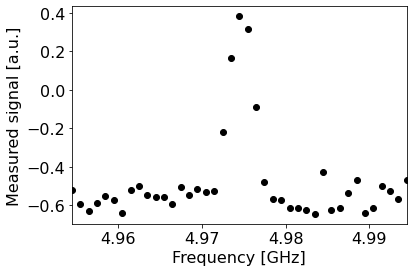

In [131]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

As you can see above, the peak near the center corresponds to the location of the qubit frequency. The signal shows power-broadening, which is a signature that we are able to drive the qubit off-resonance as we get close to the center frequency. To get the value of the peak frequency, we will fit the values to a resonance response curve, which is typically a Lorentzian shape.

In [132]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [133]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [0.2,4.8, 1, -0.6] # initial parameters for curve_fit
                                )

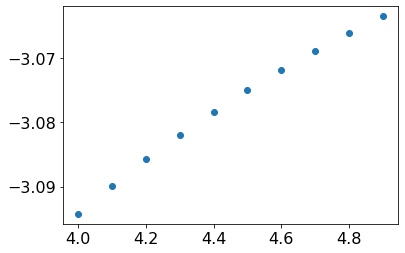

In [70]:
x = np.arange(4,5,0.1)
y = lambda x, A, q_freq, B, C: -(A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C
y(x, 4.8, 0.1, 1, -3)
plt.scatter(x,y(x, 4.8, 0.1, 1, -3))

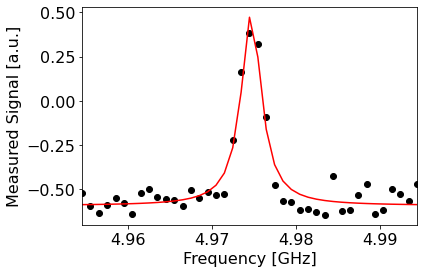

In [134]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [135]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97445 GHz to 4.97467 GHz.


## 3. Calibrating<a id="calib"></a>



We will change the drive amplitude in small increments and measuring the state of the qubit each time. We expect to see oscillations which are commonly named Rabi oscillations, as the qubit goes from $\vert0\rangle$ to $\vert1\rangle$ and back.

In [136]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [137]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

The schedule will look essentially the same as the frequency sweep experiment. The only difference is that we are running a set of experiments which vary the amplitude of the drive pulse, rather than its modulation frequency.

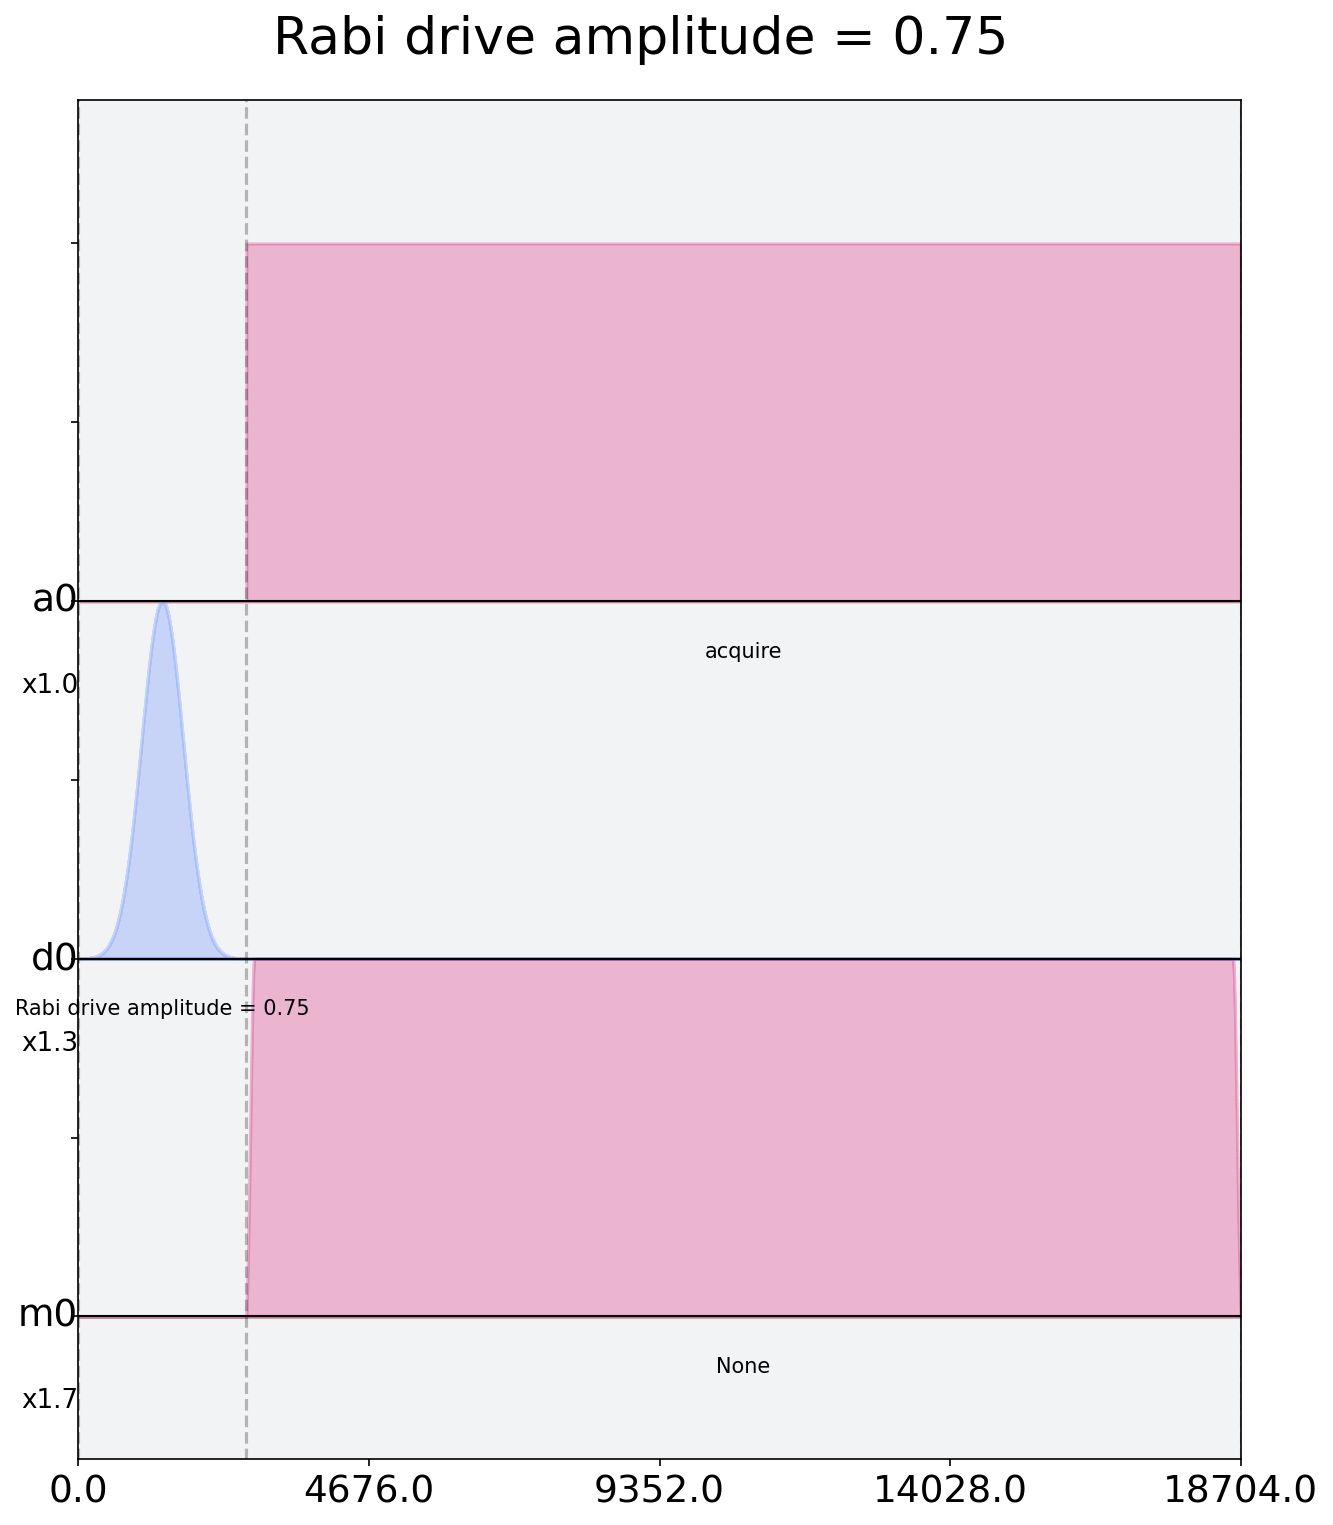

In [138]:
rabi_schedules[-1].draw(label=True)

In [139]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

/Users/Helena.Zhang@ibm.com/Documents/GitHub/frontend/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


In [140]:
job = backend.retrieve_job('5f4e7332791de500136991fc')
#job = backend.run(rabi_experiment_program)
job_monitor(job)

Job Status: job has successfully run


In [141]:
rabi_results = job.result(timeout=120)

Now that we have our results, we will extract them and fit them to a sinusoidal curve. For the range of drive amplitudes we selected, we expect that we will rotate the qubit several times completely around the Bloch sphere, starting from $|0\rangle$. The amplitude of this sinusoid tells us the fraction of the shots at that Rabi drive amplitude which yielded the $|1\rangle$ state.  We want to find the drive amplitude needed for the signal to oscillate from a maximum (all $|0\rangle$ state) to a minimum (all $|1\rangle$ state) -- this gives the calibrated amplitude that enacts a $\pi$ pulse.

In [142]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

0


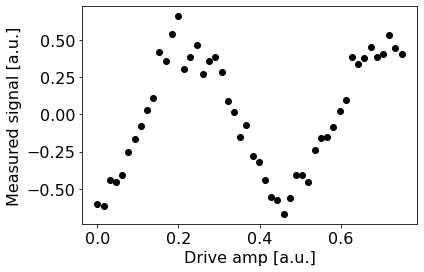

In [143]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
#     if i%3 != 0:
#         continue
    rabi_values.append(rabi_results.get_memory(i)[0]*scale_factor)
print(qubit)
rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

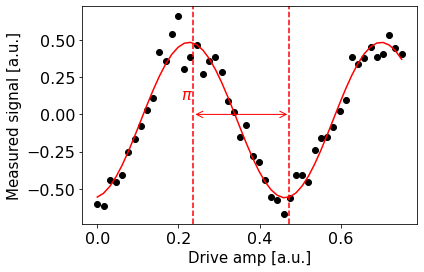

In [144]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [145]:
pi_amp = abs(drive_period / 2)
pi_amp = 0.23772202140312107
print(f"Pi Amplitude = {pi_amp}")


Pi Amplitude = 0.23772202140312107


### Our $\pi$ pulse!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

In [146]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

### 3.2 Determining 0 vs 1 <a id="zerovone"></a>

Once our $\pi$ pulses have been calibrated, we can now create the state $\vert1\rangle$ with good probability. We can use this to find out what the states $\vert0\rangle$ and $\vert1\rangle$ look like in our measurements, by repeatedly preparing them and plotting the measured signal. This is what we use to build a discriminator, which is simply a function which takes a measured and kerneled complex value (`meas_level=1`) and classifies it as a 0 or a 1 (`meas_level=2`).

In [147]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(pi_pulse, drive_chan)  # We found this in Part 2A above
exc_schedule += measure << exc_schedule.duration

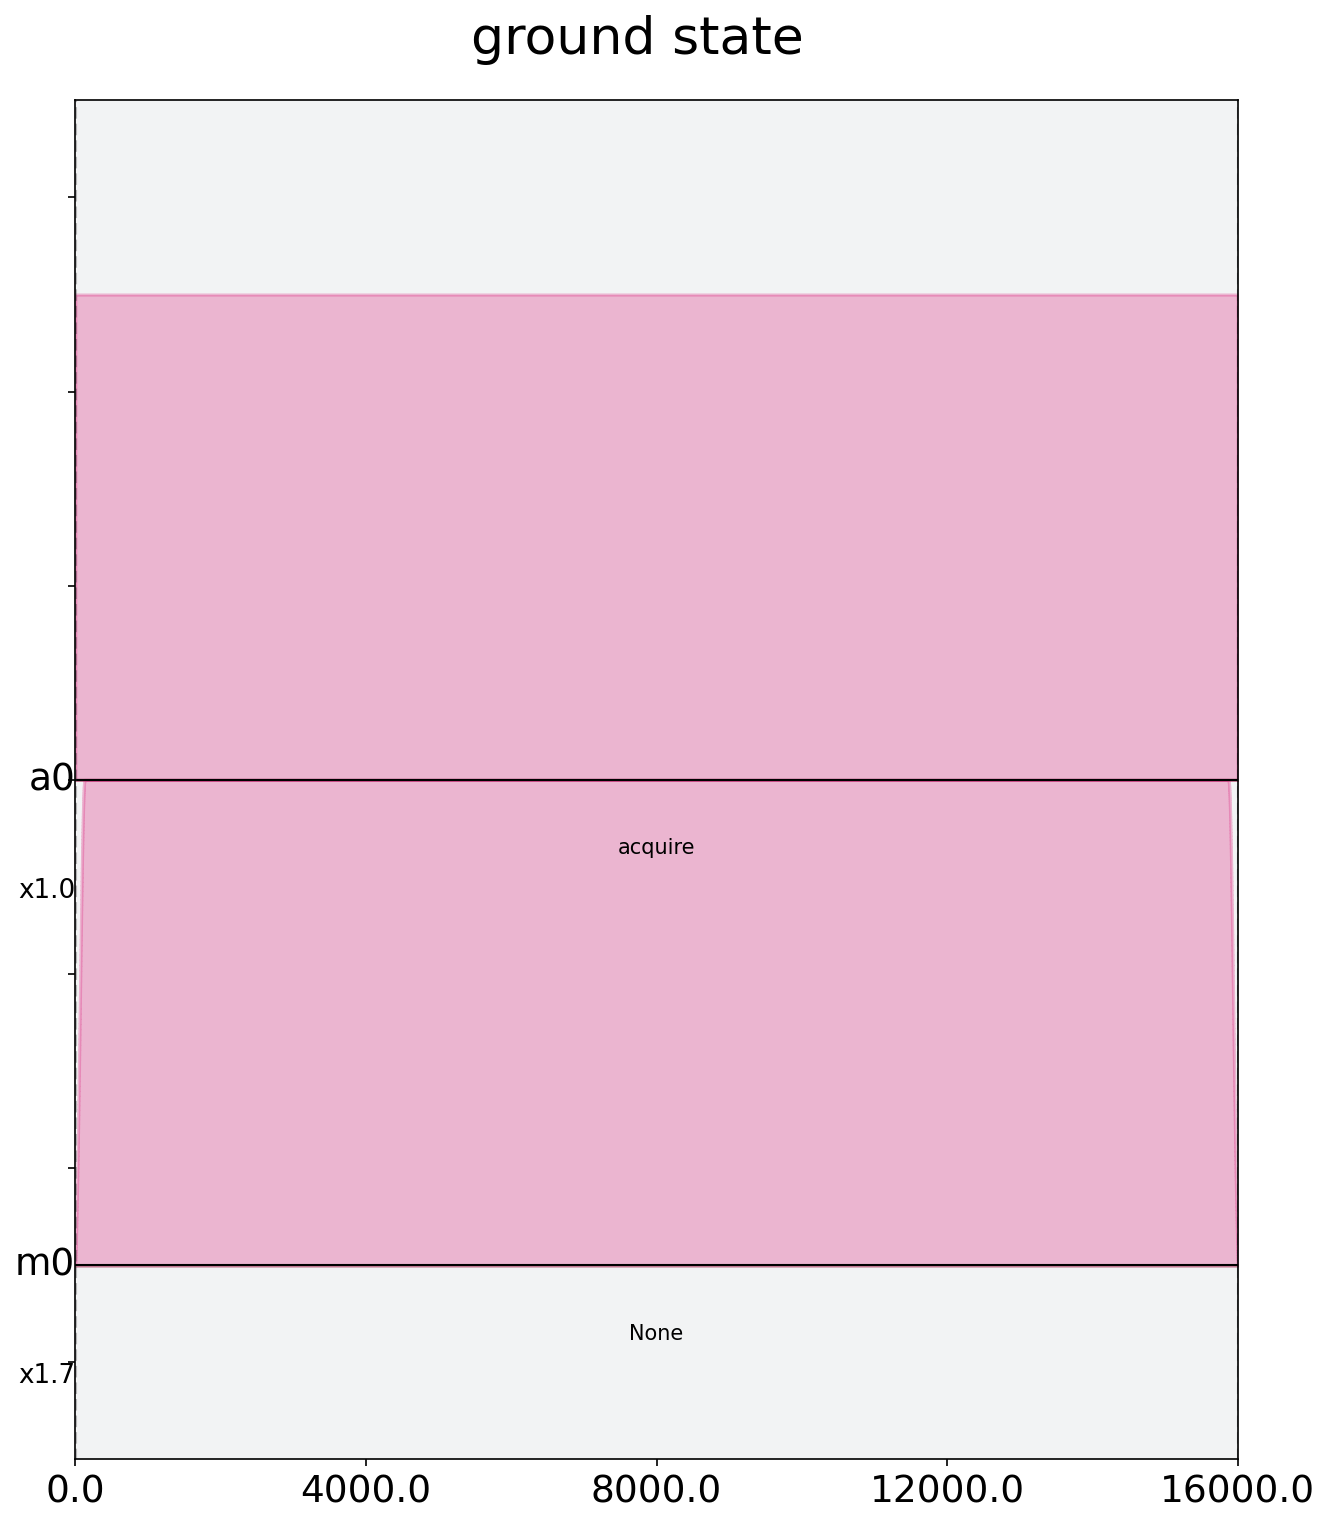

In [148]:
gnd_schedule.draw(label=True)

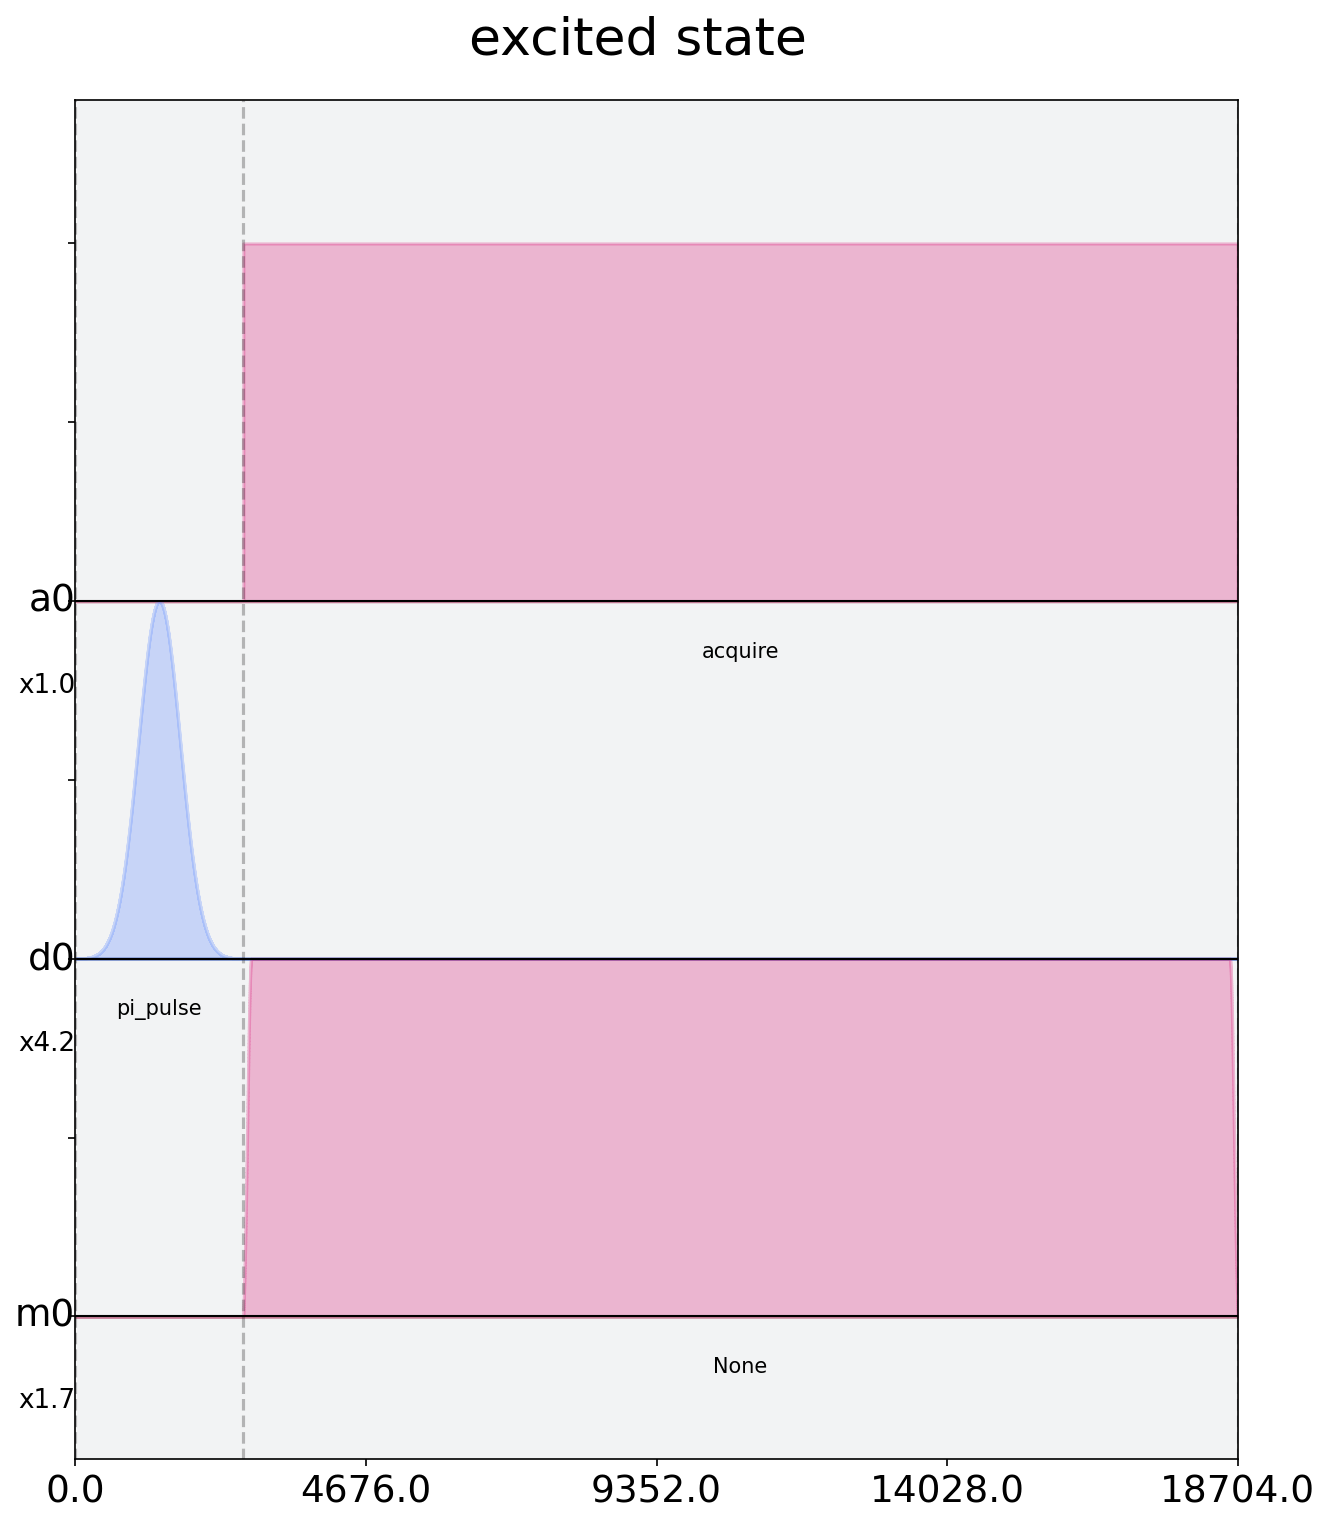

In [36]:
exc_schedule.draw(label=True)

We assemble the ground and excited state preparation schedules into one Qobj. Each of these will run `num_shots` times. We choose `meas_level=1` this time, because we do not want the results already classified for us as $|0\rangle$ or $|1\rangle$. Instead, we want kerneled data: raw acquired data that has gone through a kernel function to yield a single complex value for each shot. (You can think of a kernel as a dot product applied to the raw measurement data.)
We pass the same frequency for both schedules, although it is only used by the `exc_schedule`.

In [149]:
# Execution settings
num_shots = 1024

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

/Users/Helena.Zhang@ibm.com/Documents/GitHub/frontend/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


In [3]:
job = backend.retrieve_job('5f4e7a22a61472001284e3d9')
#job = backend.run(gnd_exc_program)
#job_monitor(job)

NameError: name 'job_monitor' is not defined

In [11]:
gnd_exc_results = job.result(timeout=120)

In [4]:
result = job.result(timeout=3600)

In [5]:
# Extract the cals from the result
def result_subset(result, names):

    new_result = deepcopy(result)
    new_results = []
    
    for res in new_result.results:
        print(res.header.name)
        if res.header.name in names:
            print("found")
            new_results.append(res)

    new_result.results = new_results
    
    return new_result

# Refactoring Ignis Discriminator

In [1]:
%load_ext autoreload
%autoreload 2
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt 
import numpy as np
from copy import deepcopy

%matplotlib inline
plt.rcParams['font.size'] = 16

import qiskit
from qiskit.result.models import ExperimentResultData
from qiskit import IBMQ

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble

from qiskit.ignis.measurement.discriminator.discriminator_generator import DiscriminatorGenerator
from qiskit.ignis.measurement.discriminator.iq_discriminator_fitter import IQDiscriminationFitter
from qiskit.providers.aer import QasmSimulator
from qiskit import execute, QuantumCircuit
from qiskit.tools.monitor import job_monitor

In [2]:
account_provider = IBMQ.load_account()
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
job = backend.retrieve_job('5f4e7a22a61472001284e3d9')
result = job.result(timeout=3600)

/Users/Helena.Zhang@ibm.com/Documents/GitHub/frontend/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Getting and running calibration circuit

In [46]:
seed_simulator = 100
num_qubits = 4

circuits2, metadata, run_config = DiscriminatorGenerator(num_qubits).run()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='dev-qiskit', project='pulse-testing')
backend = provider.get_backend('ibmq_boeblingen')

#job_cal = execute(circuits2, backend, **run_config)
job_cal = backend.retrieve_job('5f58d3d358a18b001ac30ca3')

result_cal1 = job_cal.result()

In [3]:
# Extract the cals from the result
def result_subset(result, names):

    new_result = deepcopy(result)
    new_results = []
    
    for res in new_result.results:
        if res.header.name in names:
            new_results.append(res)

    new_result.results = new_results
    return new_result

# cal_names = ['discriminator_cal_0000', 'discriminator_cal_1111']
# cal_results = result_subset(result_cal1, cal_names)

cal_names = ['ground state', 'excited state']
cal_results = result_subset(result, cal_names)

The routine below is the **core of the discriminant analysis**. A call to the constructor also fits the discriminator to the provided results. We fit one discriminator per qubit.

In [7]:
qubits = [0]
discriminators = {}

labels=['LDA', 'QDA', 'PCA']

import pprint

for i in range(3):
    discriminators[i] = IQDiscriminationFitter(cal_results = cal_results, qubit_mask=[0]).fit(method=labels[i])
    print(pprint.pformat(discriminators[i].to_dict(), compact=True))
    serialized_discriminator=discriminators[i].to_dict()

{'backend_result_list': [<qiskit.result.result.Result object at 0x13d9768e0>],
 'classifier_params': {'n_components': None,
                       'priors': None,
                       'shrinkage': None,
                       'solver': 'svd',
                       'store_covariance': False,
                       'tol': 0.0001},
 'description': 'LDA discriminator for measurement level 1.',
 'expected_state': {'excited state': 'excited state',
                    'ground state': 'ground state'},
 'fitted': True,
 'qubit_mask': [0],
 'scaler': None,
 'schedules': ['ground state', 'excited state'],
 'standardize': False,
 'xdata': [[-195065519538176.0, -30206341414912.0],
           [-191813289771008.0, -208980005617664.0],
           [-116083319111680.0, -283754899701760.0],
           [-343759317368832.0, -137179024064512.0],
           [-236647362854912.0, -112321053589504.0],
           [-118198615670784.0, -362819442704384.0],
           [-269850362511360.0, -185321580920832.0],
 

In [17]:
import copy
load_discriminator=copy.deepcopy(discriminators[2])
load_discriminator=load_discriminator.from_dict(serialized_discriminator)

We can retrieve the state of an I/Q point by calling the discriminator's **discriminate(iq_data) method**. The code below illustrates this using two points in the IQ plane `(0,0)` and `(0, -2e11)`. Depending on the results, these points will correspond a $|0\rangle$ or $|1\rangle$ state of the `test_qubit`.

In [72]:
test_qubit = 0
test_iq_data = [[0.0, 0.0], [0.0, -2.0e11],[0,2e15]]
test_states = discriminators[test_qubit].discriminate(test_iq_data)
print(discriminators[test_qubit].discriminate_state(test_iq_data))

print('Example results for qubit %i:' % test_qubit)
for idx, iq_point in enumerate(test_iq_data):
    print('IQ point ({:.0f}, {:.0f}) corresponds to state '.format(iq_point[0], iq_point[1]) + test_states[idx])

[0, 0, 1]
Example results for qubit 0:
IQ point (0, 0) corresponds to state ground state
IQ point (0, -200000000000) corresponds to state ground state
IQ point (0, 2000000000000000) corresponds to state excited state


The code below illustrates the use of the discriminator through plots and shows the decision boundary for each qubit.

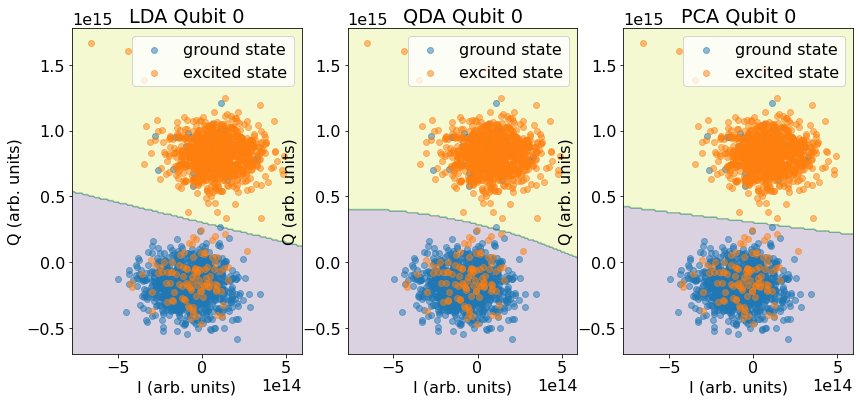

In [29]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, 3, figsize=(14,6))

expected_states = [0, 1]
XX, YY, ZZ = [], [], []
zmap={cal_names[0]: 0, cal_names[1]: 1}

for q in range(3):
    discriminators[q].plot(axs=ax[q], show_boundary=True, title=labels[q])

The `count()` method of the discriminator can now be fed experiment results to convert level 1 data into level 2 data, as the filter was doing previously.

{'0x0': 1067, '0x1': 981}


Text(0, 0.5, 'Counts')

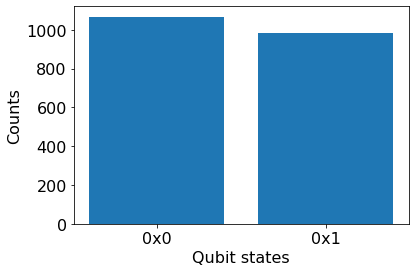

In [9]:
experiment_result=cal_results
counts=discriminators[2].count(experiment_result)
print(counts)
fig, ax = plt.subplots()
ax.bar(counts.keys(), counts.values())
ax.set_xlabel('Qubit states')
ax.set_ylabel('Counts')

Test that the serialized discriminator has the same behavior:

{'0x0': 1067, '0x1': 981}


(array([<AxesSubplot:title={'center':'Qubit 0'}, xlabel='I (arb. units)', ylabel='Q (arb. units)'>],
       dtype=object),
 None)

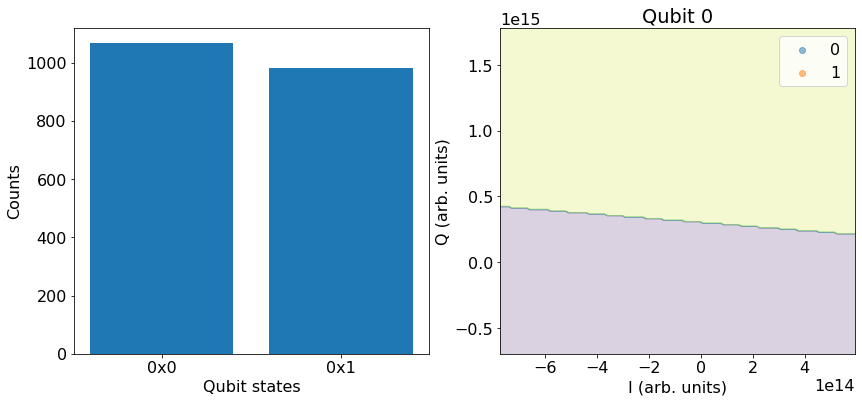

In [18]:
experiment_result=cal_results
counts=load_discriminator.count(experiment_result)
print(counts)
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].bar(counts.keys(), counts.values())
ax[0].set_xlabel('Qubit states')
ax[0].set_ylabel('Counts')
load_discriminator.plot(axs=ax[1], show_boundary=True)